In [1]:
import sys
sys.path.append("../") # go to parent dir
sys.path.append("../extract_centerline/")
sys.path.append("../extract_centerline/bin/")
sys.path.append("util/")
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Import libraries 
import time
import torch
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import numpy as np
from tqdm.notebook import tqdm
from PIL import Image
import subprocess 
import collections
import itertools
import pickle
from itertools import chain 
from statistics import mean 

# Import self-made code
import wireskeletonise 
from centerline_extraction import * 
from get_biggest_spline import * 
from util import *

# Use full browser width
from IPython.core.display import display, HTML
display(HTML(""))

# Start matlab engine 


In [3]:
# python -m ipykernel install --user --name=my-virtualenv-name
import matlab.engine
import pathlib
import os
from os import listdir
from os.path import isfile, join

# Show data
eng_start = time.time()
eng = matlab.engine.start_matlab()
print('Engine start took', time.time() - eng_start, 'seconds')

_ = eng.addpath(os.path.join(str(pathlib.Path().absolute().parents[0]), 'simulation'))
_ = eng.addpath(os.path.join(str(pathlib.Path().absolute().parents[0]), 'simulation/util'))

Engine start took 4.795102596282959 seconds


# Import segmentation methods


In [4]:
# Import models 
from Classical_methods import laplace_segmentation, laplace_segmentation_adaptive
import Unet_pytorch
import Segnet_pytorch

# Load UNet & SegNet
save_path = 'saved_models/'
num_class = 1
Unet_model = Unet_pytorch.UNet(num_class)
Segnet_model = Segnet_pytorch.SegNet(num_class)
device = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")
Unet_model.load_state_dict(torch.load(save_path+'unet_all_1', map_location=device))
Segnet_model.load_state_dict(torch.load(save_path+'segnet_all_1.pth', map_location=device))
print("Using", device)
Unet_model = Unet_model.to(device)
Segnet_model = Segnet_model.to(device)

Using cuda:0


# Import metrics


In [5]:
import metrics
HAUS_D = metrics.hausdorff_distance
MSE = metrics.MSE 
TIP_D = metrics.tip_distance  

# Evaluation 0 :
## Use validation dataset for testing 


In [ ]:
from load_data import *
import dataset
from sklearn.model_selection import train_test_split

X, y, pts = load_data('.', '../data/dataset_all_1', v73 = True)
batch_size = 5
test_length = round(y.shape[0] * 0.2)
pts = np.transpose(pts,(2,1,0))
pts = pts[:,:,::-1]
X_train, y_train, X_test, y_test = X[:-test_length], y[:-test_length], X[-test_length:], y[-test_length:]
pts_train, pts_test = pts[:-test_length], pts[-test_length:]
dataloaders = dataset.gen_dataloaders(X_train, X_test, pts_train, y_train, y_test, pts_test, batch_size)

In [6]:
def evaluate_method(method, metric, name, n = None):
    metrics = []
    
    for i, (simulated, ground_truth, points) in tqdm(enumerate(dataloaders['val'])):
        if n is not None and i >= n:
            break
        segmented = method(simulated.float().squeeze(1).detach().numpy())

        if metric == MSE:
            values_batch = metric(segmented, ground_truth.numpy())  
            metrics.append(values_batch)
            
        else:        
            if not isinstance(segmented,bool):
                segmented = np.squeeze(segmented>0.2)

            for i,(seg,gt_pt) in enumerate(zip(segmented,points)): 
                if name == 'Laplace filter':
                    centerline, cl_pt = get_centerline(seg,original_dir,'binary',pre_process=0)
                else:
                    centerline, cl_pt = get_centerline(seg,original_dir,'binary')
                if cl_pt.size != 0:
                    cl_pt = np.flip(cl_pt,axis=0)  
                    cl_pt_1 = cl_pt[-1]
                    #fig, ax = plt.subplots(1,2)
                    #ax[0].imshow(ground_truth[i].numpy(), cmap='gray')
                    #ax[0].scatter(gt_pt[:,0],gt_pt[:,1], color='b')
                    #ax[1].imshow(centerline,cmap='gray')
                    #ax[1].scatter(cl_pt_1[0],cl_pt_1[1],color='r')
                    #ax[1].scatter(gt_pt[len(gt_pt)-1,0],gt_pt[len(gt_pt)-1,1], color='b')
                    #plt.show()
                    if metric == TIP_D: 
                        metrics.append(metric(gt_pt.numpy(),cl_pt))
                    elif metric == HAUS_D: 
                        metrics.append(metric(gt_pt.numpy(),cl_pt))
                else: 
                    #plt.imshow(seg,cmap='gray')
                    #plt.show()
                    pass
                    
    if np.ndim(np.array(metrics)) == 2:
        return np.array(metrics).mean(axis=0)  
    else:
        return np.array(metrics).mean()        


In [7]:
methods = {'Laplace filter': lambda x: np.array([laplace_segmentation_adaptive(x_i,sigma=6,adaptive_threshold=0.85) for x_i in x]),
           #'Random forest': lambda x: np.array([rf_segmentation(x_i) for x_i in x]),
           'UNet': lambda x: Unet_model((torch.Tensor(x).unsqueeze(1).to(device))).detach().cpu().numpy(),
           'SegNet': lambda x: Segnet_model((torch.Tensor(x).unsqueeze(1).to(device))).detach().cpu().numpy()}


In [ ]:
%cd ../segmentation
original_dir= os.getcwd()
print(original_dir)

for name, method in methods.items():
    score = evaluate_method(method, MSE,name).mean()
    print(f'{name} had MSE of {score}')
    score = evaluate_method(method, TIP_D,name)
    print(f'{name} had TIP_D of {score}')
    [score_avg, score_max] = evaluate_method(method, HAUS_D,name)
    print(f'{name} had AVG HAUS_D of {score_avg}')
    print(f'{name} had MAX HAUS_D of {score_max}') 

# Evaluation 1 :

## Ablation study

In [8]:
im_size = eng.cell2mat([256.0, 192.0])
eng.addpath('util/')

def evaluate_ablation(methods, metric, spline_metric, parameters, loop_prob = 0.7, verbose=0, n_samples=1, experiment='test'):

    # Create results directory
    results_dir = 'results/'+experiment+'/'
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
        
    # Define varying parameter 
    variants = [v for v in parameters.keys() if len(np.unique(parameters[v])) > 1]
        
    if len(variants) == 0: 
        print(f'Warning, varying {len(variants)} parameter(s)')
        variant = 'Spline'
        variant_pars = [0]
        n_values = 1
        for key, value in parameters.items():
            parameters[key] = [value[0]]
    else: 
        variant = variants[0]
        print(f'Varying {variant}...')
        variant_pars = parameters[variants[0]]
        n_values = len(variant_pars)
    
    # Simulate the images for varying parameter
    sim_start = time.time()
    blur_filter = eng.gen_blur_filter(float(250), float(1.3));
    simulated_images = [[0 for x in range(n_values)] for y in range(n_samples)]
    ground_truths = [[0 for x in range(n_values)] for y in range(n_samples)]
    ground_truth_pts = [[0 for x in range(n_values)] for y in range(n_samples)]
    
    for n in range(n_samples):
        seed = eng.rng('shuffle') 
        pts, _ = eng.gen_spline_realistic(im_size, 100.0, loop_prob, nargout = 2)
        gt_pts = np.array(pts._data).reshape(pts.size, order='F').T 
        gt_pts = gt_pts[:,1:]
        gt_pts[:,[0, 1]] = gt_pts[:,[1, 0]]   
        
        for i, (s, u, us, tc, sa, ra) in enumerate((np.array(list(parameters.values())).T.tolist())):
            eng.rng(seed)
            #eng.rng(1234)
            ground_truth, simulated = np.array(eng.simulate(pts,im_size,blur_filter,1,0,0, 
                                                            eng.cell2mat([s, s]), 
                                                            eng.cell2mat([tc,tc]),
                                                            eng.cell2mat([u, u]),
                                                            eng.cell2mat([us,us]),
                                                            eng.cell2mat([sa,sa]),
                                                            eng.cell2mat([ra,ra]),nargout=2))
            simulated_images[n][i] = simulated
            ground_truths[n][i] = ground_truth
            ground_truth_pts[n][i] = gt_pts

    # Segment using every method
    simulated_images, ground_truths = np.array(simulated_images), np.array(ground_truths)
    segmented, scores_spline, _centerlines, _splines = {}, {}, {}, {}
    segmented = collections.defaultdict(list)
    metric_dic = collections.defaultdict(dict)

    for name, method in methods.items():
        for image in simulated_images:
            segmented[name].append(method(image)) 

        for m in metric: 
            metric_value = [[0 for x in range(n_values)] for y in range(n_samples)]
            for i,(seg, gt) in enumerate(zip(segmented[name],ground_truths)):
                metric_value[i] = m(seg,gt)
            metric_dic[m.__name__][name] = metric_value
        
        for s in spline_metric: 
            centerlines = [[0 for x in range(n_values)] for y in range(n_samples)]
            cl_pts = [[0 for x in range(n_values)] for y in range(n_samples)]
            
            if s.__name__ == 'hausdorff_distance':
                metric_dic['average_hausdorff'].setdefault(name,[[] for x in range(n_samples)])
                metric_dic['maximum_hausdorff'].setdefault(name,[[] for x in range(n_samples)])
            else: 
                metric_dic[s.__name__].setdefault(name,[[] for x in range(n_samples)])
            
            for nn, (seg, gt_pts) in enumerate(zip(segmented[name], ground_truth_pts)):
                for ii,(v, v_pt) in enumerate(zip(seg,gt_pts)): 
                    v = np.squeeze(v)
                    if not isinstance(v,bool):
                        v = v>0.2
                    if name == 'Laplace filter':
                        centerline, cl_pt = get_centerline(v,original_dir,'binary', pre_process=0)
                    else:
                        centerline, cl_pt = get_centerline(v,original_dir,'binary')
                    
                    if cl_pt.size != 0:
                        cl_pt = np.flip(cl_pt,axis=0)  
                        centerlines[nn][ii] = centerline
                        cl_pts[nn][ii] = cl_pt[-1]    
                        if s.__name__ == 'hausdorff_distance':
                            average, maximum = s(v_pt,cl_pt)
                            metric_dic['average_hausdorff'][name][nn].append(average)
                            metric_dic['maximum_hausdorff'][name][nn].append(maximum)
                        else: 
                            metric_dic[s.__name__][name][nn].append(s(v_pt,cl_pt))
                    else: 
                        centerlines[nn][ii] = centerline
                        cl_pts[nn][ii] = [0,0]
                        if s.__name__ == 'hausdorff_distance':
                            metric_dic['average_hausdorff'][name][nn].append(np.nan)
                            metric_dic['maximum_hausdorff'][name][nn].append(np.nan)
                        else: 
                            metric_dic[s.__name__][name][nn].append(np.nan)
                    
        _centerlines[name] = np.array(centerlines)
        _splines[name] = np.array(cl_pts)
    
    
    ## START DISPLAY ## 
    visualisation_simulated = simulated_images[0,:,:,:]
    visualisation_ground_truths = ground_truths[0,:,:,:]
    visualisation_ground_truth_pts = np.array(ground_truth_pts)[0,:,:,:]

    # Plot qualitative results (input and outpus of each method) 
    for i, method in enumerate(methods.keys()):
        
        visualisation_segmented = np.array(segmented[method])[0,:,:,:]
        visualisation_centerlines = np.array(_centerlines[method])[0,:,:,:]
        visualisation_splines = np.array(_splines[method])[0,:,:]
                
        fig = plt.figure(figsize=[17, 8])
        fig.suptitle(f'Segmentation output ({method})\n for varying {variant}', fontsize=18)    
        ax = [plt.subplot(3,n_values,i+1) for i in range(3 * n_values)]
        for i, (v, sim, gt, out, lin, pts, gt_pts) in enumerate(zip(variant_pars,visualisation_simulated,visualisation_ground_truths,visualisation_segmented,visualisation_centerlines,visualisation_splines,visualisation_ground_truth_pts)):
            ax[i].imshow(sim, cmap='gray')
            ax[i].axis('off')
            if len(variants) == 1:
                ax[i].set_title(round(v, 2))
            ax[i + n_values].axis('off')
            try:
                ax[i + n_values].imshow(out.squeeze(0), cmap='gray')
            except:
                ax[i + n_values].imshow(out,cmap='gray')
            ax[i + n_values*2].axis('off')
            ax[i + n_values*2].imshow(lin, cmap='gray')
            ax[i + n_values*2].scatter(pts[0],pts[1],color='r')
            ax[i + n_values*2].scatter(gt_pts[len(gt_pts)-1,0],gt_pts[len(gt_pts)-1,1], color='b')
        ax[0].axis('on')
        ax[0].set_yticklabels([])
        ax[0].set_xticklabels([])
        ax[0].tick_params(axis=u'both', which=u'both',length=0)        
        ax[0].set_ylabel('Input',fontsize =15)
        ax[n_values*1].axis('on')
        ax[n_values*1].set_yticklabels([])
        ax[n_values*1].set_xticklabels([])
        ax[n_values*1].tick_params(axis=u'both', which=u'both',length=0)        
        ax[n_values*1].set_ylabel('Segmentation',fontsize = 15)
        ax[n_values*2].axis('on')
        ax[n_values*2].set_yticklabels([])
        ax[n_values*2].set_xticklabels([])
        ax[n_values*2].tick_params(axis=u'both', which=u'both',length=0)        
        ax[n_values*2].set_ylabel('Spline', fontsize = 15)
        plt.subplots_adjust(wspace=-0.85, hspace=0.1)
        name = fig._suptitle.get_text().replace(" ", "_") 
        if verbose: 
            plt.savefig(results_dir+name, bbox_inches = 'tight',pad_inches = 0)
        plt.show()
    
    print('Evaluation took', time.time() - sim_start, 'seconds')
    
    return metric_dic, variant, variant_pars
    

In [9]:
def plot_metric(metric_dic, variant, pars, training_value=0, verbose = 0, directory = None): 
    
    # Plot performance of metrics against the changing parameter
    for k,v in metric_dic.items():
        fig,ax1 = plt.subplots(figsize=(15,8))
        colors = itertools.cycle(["r", "b", "g"])

        plots = {}
        for i, (kk,vv) in enumerate(v.items()):
            
            c = next(colors)
            ax = ax1
            if kk == 'Laplace filter':
                ax2=ax.twinx()
                ax = ax2
                ax.set_ylabel('Laplace filter axis', fontsize = 30)
                ax.tick_params(axis='both', which='major', labelsize=20)
            mean_metric = np.nanpercentile(vv, 50, axis=0)
            lower_quantile = np.nanpercentile(vv, 25, axis=0)
            upper_quantile = np.nanpercentile(vv, 75, axis=0)
            plots["n.{0}".format(i)] = ax.plot(pars, mean_metric, lw=2, label=kk, color=c)
            ax.fill_between(pars, lower_quantile, upper_quantile, facecolor=c, alpha=0.2)
        
        lns = plots["n.0"] + plots["n.1"] + plots["n.2"]
        labs = [l.get_label() for l in lns]
        if training_value:
            plt.axvline(training_value,ls='--',color='k')
        ax.legend(lns, labs, loc=0, fontsize = 25)          
        ax.set_xlabel(variant, fontsize = 30)
        ax.set_ylabel(k, fontsize = 30)   
        ax.set_title(f'{k} against varying {variant}', fontsize=30)
        fig.tight_layout()
        ax.tick_params(axis='both', which='major', labelsize=20)
        name = (f'{k}_against_varying_{variant}').replace(" ", "_") 
        
        if verbose:
            plt.savefig(directory + name, bbox_inches ='tight', pad_inches = 0)
        plt.show()

In [ ]:
%cd ../segmentation
original_dir= os.getcwd()
print(original_dir)

n_values = 3 
def_parameters = {}

# Change parameter to vary
def_parameters['sigma'] = [0.1] * n_values
def_parameters['undersampling_factor'] = [1.0] * n_values
def_parameters['undersampling_spread'] = [1.0] * n_values
def_parameters['tip_current'] = [0.8] * n_values
def_parameters['size_anatomy'] = [0.5] * n_values
def_parameters['ratio_anatomy'] = [0.8] * n_values

# Example for 2 splines
parameters = def_parameters.copy()
parameters['undersampling_spread'] = np.linspace(0.0, 0.5, num=n_values).tolist()
[metrics, variant, variant_pars] = evaluate_ablation(methods,[MSE],[TIP_D,HAUS_D], parameters, verbose=1, n_samples=100, experiment='final_v1')
plot_metric(metrics, variant, variant_pars, training_value=0.2, verbose =1, directory = 'results/final_v1/')


# Evaluation 2 :

## Comparison between varying parameters

In [10]:
def save_obj(obj, name):
    with open('results/final_v1/metrics/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


In [ ]:
%cd ../segmentation
original_dir= os.getcwd()
print(original_dir)
n_values = 8 
def_parameters = {}

# Change parameter to vary
def_parameters['sigma'] = [0.1] * n_values
def_parameters['undersampling_factor'] = [1.0] * n_values
def_parameters['undersampling_spread'] = [1.0] * n_values
def_parameters['tip_current'] = [0.8] * n_values
def_parameters['size_anatomy'] = [0.5] * n_values
def_parameters['ratio_anatomy'] = [0.8] * n_values

# Change sigma
parameters = def_parameters.copy()
parameters['sigma'] = np.linspace(0, 0.5, num=n_values).tolist()
[metrics, variant, variant_pars] = evaluate_ablation(methods,[MSE],[TIP_D,HAUS_D], parameters, verbose=0, n_samples=300, experiment='final_v1')
save_obj(metrics['tip_distance'],'sigma')

# Change undersampling factor
parameters = def_parameters.copy()
parameters['undersampling_factor'] = np.linspace(0.5, 1.0, num=n_values).tolist()
[metrics, variant, variant_pars] = evaluate_ablation(methods,[MSE],[TIP_D,HAUS_D], parameters, verbose=0, n_samples=300, experiment='final_v1')
save_obj(metrics['tip_distance'],'undersampling_factor')

# Change undersampling spread
parameters = def_parameters.copy()
parameters['undersampling_spread'] = np.linspace(0.4, 1.0, num=n_values).tolist()
[metrics, variant, variant_pars] = evaluate_ablation(methods,[MSE],[TIP_D,HAUS_D], parameters, verbose=0, n_samples=300, experiment='final_v1')
save_obj(metrics['tip_distance'],'undersampling_spread')

# Change tip current 
parameters = def_parameters.copy()
parameters['tip_current'] = np.linspace(0, 1.0, num=n_values).tolist()
[metrics, variant, variant_pars] = evaluate_ablation(methods,[MSE],[TIP_D,HAUS_D], parameters, verbose=0, n_samples=300, experiment='final_v1')
save_obj(metrics['tip_distance'],'tip_current')

# Change size anatomy 
parameters = def_parameters.copy()
parameters['size_anatomy'] = np.linspace(0, 1.0, num=n_values).tolist()
[metrics, variant, variant_pars] = evaluate_ablation(methods,[MSE],[TIP_D,HAUS_D], parameters, verbose=0, n_samples=300, experiment='final_v1')
save_obj(metrics['tip_distance'],'size_anatomy')

# Change ratio anatomy
parameters = def_parameters.copy()
parameters['ratio_anatomy'] = np.linspace(0.6, 1.0, num=n_values).tolist()
[metrics, variant, variant_pars] = evaluate_ablation(methods,[MSE],[TIP_D,HAUS_D], parameters, verbose=0, n_samples=300, experiment='final_v1')
save_obj(metrics['tip_distance'],'ratio_anatomy')

/home/mmu18/Desktop/Projects/AIWire/segmentation
/home/mmu18/Desktop/Projects/AIWire/segmentation
Varying sigma...


               method    value             parameter
0      Laplace filter  2.61055          size_anatomy
1      Laplace filter  4.66994          size_anatomy
2      Laplace filter  4.77788          size_anatomy
3      Laplace filter   3.5798          size_anatomy
4      Laplace filter  152.208          size_anatomy
...               ...      ...                   ...
43195          SegNet  4.67826  undersampling_spread
43196          SegNet  3.31325  undersampling_spread
43197          SegNet  4.67826  undersampling_spread
43198          SegNet  6.14029  undersampling_spread
43199          SegNet  6.90675  undersampling_spread

[43200 rows x 3 columns]


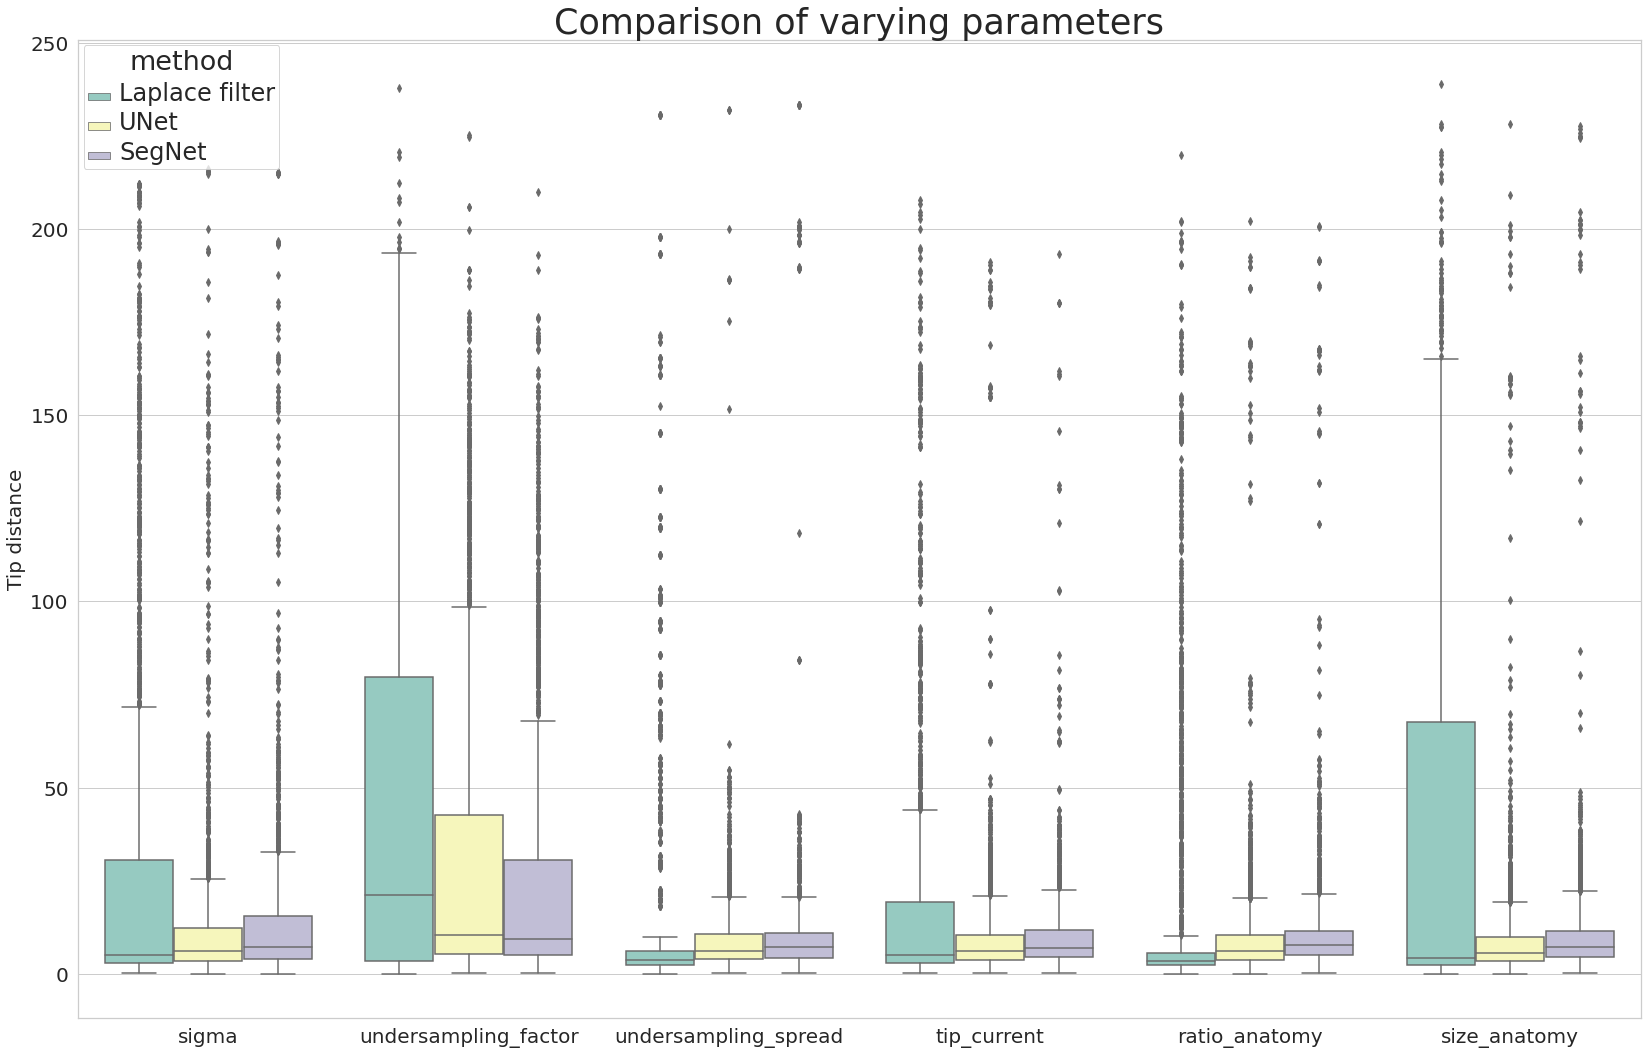

In [13]:
import seaborn as sns
import pandas as pd
sns.set(style="whitegrid")

def create_boxplot(verbose=0,save_name=None):
    mypath = 'results/final_v1/metrics/'
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    parameters = {}
    fig = plt.figure(figsize=[28,18])
    ax = plt.subplot(111)
    ax.set_title('Comparison of varying parameters', fontsize=35)    
    jj = 0
    complete_df=pd.DataFrame()
    for i in onlyfiles:
        file = pickle.load(open(mypath+i, 'rb'))
        name = str(i).split('.')
        df = pd.DataFrame([(key, var) for (key, L) in file.items() for var in L], columns=['method', 'value'])
        df = df.explode('value').reset_index(drop=True)
        df['parameter'] = name[0]
        complete_df=complete_df.append(df,ignore_index=True)
    print(complete_df)
    #complete_df = complete_df[complete_df['method'] == 'SegNet']
    ax = sns.boxplot(x="parameter", y="value", hue="method", order=['sigma','undersampling_factor','undersampling_spread','tip_current','ratio_anatomy', 'size_anatomy'], 
                     data=complete_df, palette="Set3")
    ax.set_ylabel("Tip distance",fontsize=20)
    ax.xaxis.label.set_visible(False)
    ax.tick_params(labelsize=20)
    plt.setp(ax.get_legend().get_texts(), fontsize='24') # for legend text
    plt.setp(ax.get_legend().get_title(), fontsize='27') # for legend title
    if verbose:
        plt.savefig(mypath + save_name, bbox_inches ='tight', pad_inches = 0.5)
    plt.show()
    
create_boxplot(1,save_name='boxplots/boxplot_v3')